This project utilizes the data from the <i>Store Sales -- Time Series Analysis</i> Kaggle competition. The goal is to explore the data and create a model to forecast the sales of stores in Ecuador based on the given features or those that are engineered. 

<b>Note</b>: If viewing this file directly in GitHub, it will not display any visualization generated using Plotly. Please use the link in the Portfolio README to view on the Jupyter Notebook file using https://nbviewer.org/.

<h1>0. Import data and libraries</h1>

In [1]:
# Data analysis and cleaning
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

# Time Series
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from scipy.signal import periodogram

# Modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from yellowbrick.regressor.alphas import alphas

# Other
from itertools import product
from math import floor
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
transactions = pd.read_csv('transactions.csv')
oil = pd.read_csv('oil.csv')
holidays_events = pd.read_csv('holidays_events.csv')

datasets = [train, test, stores, transactions, oil, holidays_events]

<h1>1. Exploratory Data Analysis</h1>

First, a quick run through the descriptive statistics of each dataframe available. Some of the statistics will not be meaningful, such as the mean store number, but this is a quick and efficient way to gather that which is meaningful.

In [3]:
for df in datasets:
    print(df.info(), '\n\n', df.describe())
    print('\n','='*45,'\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None 

                  id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02



<class 'pandas.core.frame.DataFrame'>
RangeInde

The most basic and foundational visualization to begin with is total sales per day. Alongside this total will be the weekly moving average.

<b>Methods of Smoothing:</b>
* <i>Moving Average</i>


* <i>Weighted Average</i>: moving average with larger weight assigned to more recent data and weights summing up to 1


* <i>Single Exponential Smoothing</i>: All previous data holds weight, but at an exponentially decaying rate
<p style="padding-left: 20px;">$\hat{s}_{t} = \alpha x_{t}+(1-\alpha)s_{t-1} = \alpha x_{t}+\alpha(1-\alpha)x_{t-1}+\alpha(1-\alpha)^{2}x_{t-2} + ... $</p><br>
where $0 ≤ \alpha ≤ 1$ is the smoothing parameter and <i>s</i> is the smoothed value (level) There are various methods of determining the initial smoothed value $s_{0}$.


* <i>Double Exponential Smoothing</i>: This method extends single exponential smoothing to also smooth trend.
<p style="padding-left: 20px;">$s_{t} = \alpha x_{t}+(1-\alpha)(s_{t-1}+b_{t-1})$<br>
$b_{t} = \beta(s_{t}-s_{t-1})+(1-\beta)b_{t-1}$</p><br>
where $\alpha$ is the <i>data smoothing factor</i> and $\beta$ is the <i>trend smoothing factor</i>


* <i>Triple Exponential Smoothing / Holt-Winters</i>: This method extends double exponential smoothing to also smooth seasonality. To be brief, this can be performed with either an additive or multiplicative method.




In [4]:
# Create df with daily unit sales
df_daily = train.loc[:, ['date', 'sales', 'onpromotion']]
df_daily = df_daily.groupby('date').sum()

# Date is the index, which cannot be passed for the x-axis, 
# so index must be reset
df_daily.reset_index(inplace=True)

# Compute 7 day moving/rolling average
df_daily['week_moving_avg'] = df_daily.sales.rolling(7).mean()

trace0 = go.Scatter(
    x=df_daily.date,
    y=df_daily.sales,
    mode='lines',
    name='Daily Unit Sales',
    marker_color='#537A5A')

trace1 = go.Scatter(
    x=df_daily.date,
    y=df_daily.week_moving_avg,
    mode='lines',
    name='Weekly Moving Average',
    marker_color='#93c47d')

layout = go.Layout(
    title='Unit Sales by Date',
    title_x=0.3,
    title_y=0.9,
    template='plotly_white',
    hovermode='x unified')

go.Figure(data=[trace0, trace1], layout=layout)
# An alternative method is passing multiple variables for y in plotly express 

In [5]:
def get_year_month(df):
    """
    Create year and month columns using date column. This occurs in place.
    """
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].apply(lambda x: x.year)
    df['month'] = df['date'].apply(lambda x: x.month)
    
df_month = df_daily.loc[:,['date', 'sales', 'onpromotion']]
get_year_month(df_month)
df_month = df_month.groupby(['year', 'month']).mean()
# Month is the index, which cannot be passed a column for the graph,
# so df index must be reset
df_month.reset_index(inplace=True)

In [6]:
month_name =[
    'Jan', 'Feb', 'Mar', 'April', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
cmap = [
    '#17869E', '#51C4D3', '#B4DBE9', '#8CA251', '#B4CF6B', '#CEDB9C',
    '#AD494A', '#D6616B', '#E7969C', '#BD9E39', '#E7BA52', '#E7CB94']
  
# plotly express does not support arbitrary subplots, 
# so instead they must be created with the lower-level graph_objs
# Initialize Subplots
fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{'type': 'scatter'}, {'type':'bar'}]],
    column_widths=[0.43,0.57])

# Layout
fig.update_layout(
    title='Sales by Month',
    title_x=0.46,
    template='plotly_white',
    hovermode='x unified',
    barmode='stack',
    showlegend=False)

# Subplot 1: Line
color = 0 
for year, sales in df_month.groupby('year'):
    fig.add_trace(
        go.Scatter(
            x=sales.month,
            y=sales.sales,
            name=year,
            mode='lines',
            line_color = px.colors.qualitative.Antique[color]),
        row=1,
        col=1)
    color += 1

fig.update_xaxes(
    row=1, col=1,
    title_text='Month',
    tickvals=[1,2,3,4,5,6,7,8,9,10,11,12],
    ticktext=month_name)
fig.update_yaxes(row=1, col=1, title_text='Units Sold')

# Subplot 2: Stacked Bar 
count=0
for month in month_name:
    fig.add_trace(
        go.Bar(
            name=month_name[count],
            x=df_month.year.unique(),
            y=df_month.loc[df_month['month']==(count+1),'sales'],
            marker_color=cmap[count]),
        row=1, col=2)
    count += 1

fig.show()

While the year-to-year trend is clearly increasing, the month-to-month trend does not appear to be particularly consistent. Each month has seen an increase or decrease in sales to varying degrees, except for December. Given this variability, a <i>month</i> feature would not be reliable in a forecasting model. Instead, a boolean feature <i>is_december</i> will be used because the increase in sales during december has been unanimous throughout the data.

In [7]:
fig = px.scatter(
    df_daily, x='date', y='sales',
    color='onpromotion',
    color_continuous_scale='earth',
    title='Total Unit Sales and Items on Promotion')
fig.update_layout(
    {'xaxis': {'title':'Date'},
    'yaxis': {'title':'Average Units Sold'}},
    template='plotly_white',
    title_x=0.475)
fig.show()

In [8]:
df_dofw = df_daily.loc[:, ['date', 'sales']]
get_year_month(df_dofw)
df_dofw['dofw'] = df_dofw['date'].apply(
    lambda x: x.day_name())
df_dofw = df_dofw.groupby(['dofw','year']).sum().reset_index()

fig = go.Figure()

for day in [
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'
]:
    if day in ['Saturday','Sunday']:
        color = '#51C4D3'
    else: 
        color = '#17869E'    
    fig.add_trace(
        go.Bar(
            x=df_dofw['year'],
            y=df_dofw['sales'].loc[df_dofw['dofw']==day],
            name=day,
            marker_color=[color]*5))
    
fig.update_layout(
    title='Total Sales by Day of Week',
    title_x=0.3,
    title_y=0.85,
    width=750,
    height=400,
    template='plotly_white')
fig.show()

Note that 2017 has lower total sales because the data does not extend to the end of the year. Weekdays vs weekends certainly display the greatest difference in sales, but also the comparison of each individual day is quite consistent throughout the years. For this reason, the <i>day_of_week</i> feature will be included when forecasting instead of simplifying this to a boolean feature <i>is_weekend</i>.

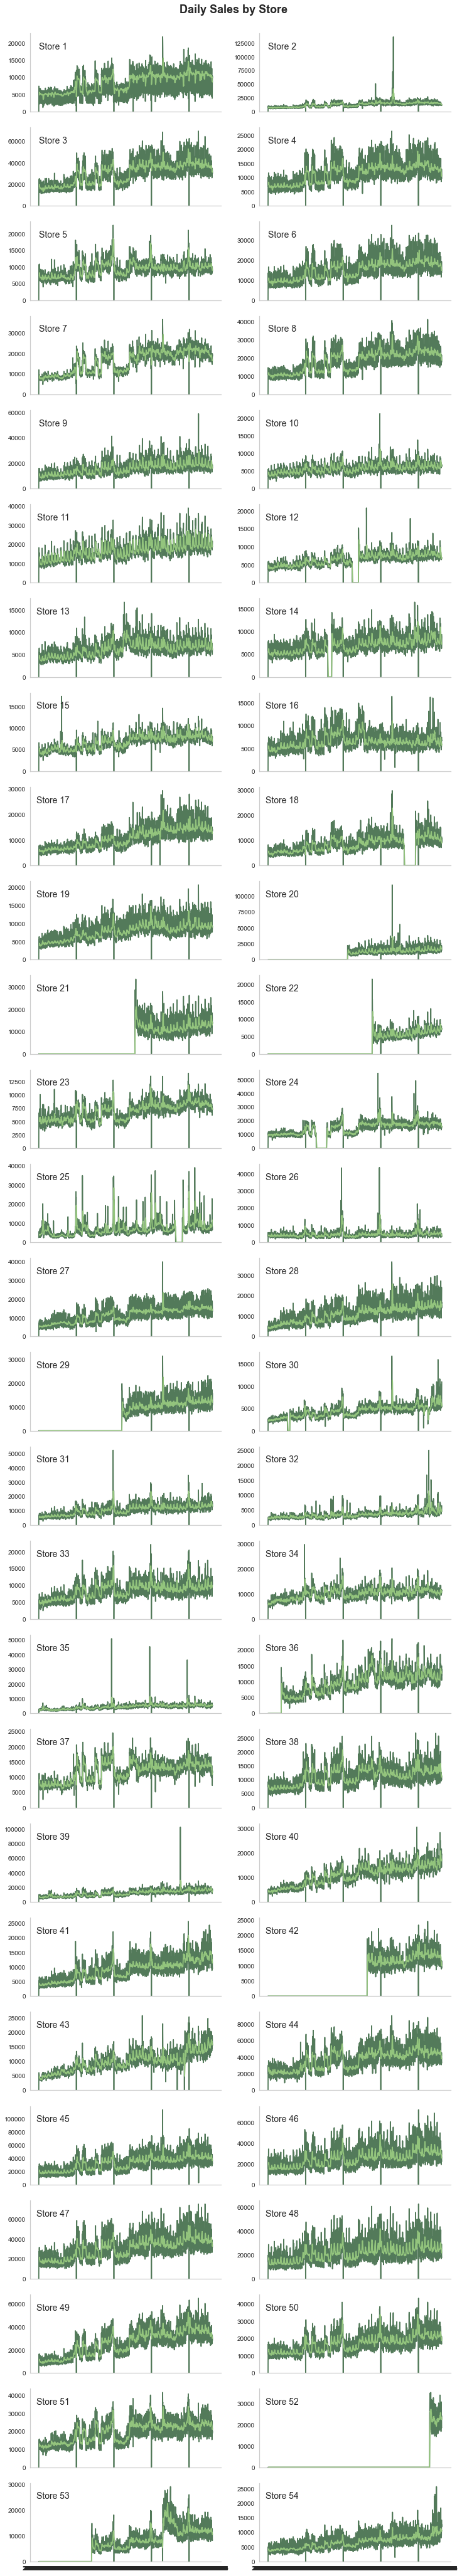

In [9]:
# Create df of daily sales by each store
df_daily_store = train.copy()
df_daily_store = df_daily_store.loc[:,['date', 'sales', 'store_nbr']]
df_daily_store = df_daily_store.groupby(['date','store_nbr']).sum()

# Date is the index, which cannot be passed for the x-axis, 
# so df index must be reset
df_daily_store.reset_index(inplace=True)

# Create moving average column based on each store's sales
df_daily_store['week_moving_avg'] = None

for store in df_daily_store.store_nbr.unique():
    df = df_daily_store.loc[df_daily_store['store_nbr']==store,:]
    df_daily_store['week_moving_avg'].loc[df_daily_store['store_nbr']==store] = df.sales.rolling(7).mean()

# Create Figure and subplots
sns.set_style('whitegrid')
fig, axs = plt.subplots(27, 2, figsize=(12,64), sharex=True)
sns.despine(fig)
fig.suptitle('Daily Sales by Store', fontsize=18, fontweight=600, y=1.01)
fig.subplots_adjust(top=1)

# Plots
plot=0
for store in df_daily_store.store_nbr.unique():
    ax=axs[floor(plot/2), plot%2]
    sns.lineplot(
        data=df_daily_store.loc[df_daily_store['store_nbr']==store],         
        x='date',
        y='sales',
        color='#537A5A',
        ax=ax)
    sns.lineplot(
        data=df_daily_store.loc[df_daily_store['store_nbr']==store],
        x='date',
        y='week_moving_avg',
        color='#93c47d',
        ax=ax)
    ax.set(
        ylabel=None,
        xlabel=None,
        ylim=(0,None))
    ax.set_title(
        f'Store {store}',
        y=0.75,
        x=0.12,
        fontdict={'size':14,'weight':500})
    ax.grid(False)
    plot += 1

Several stores have no sales for an extended period of time--these stores likely had not started business yet or the data is not available. These stores and dates will be considered when forecasting and will be placed in the <i>stores_closed</i> dataframe. A more explicit view of store closures can be seen below:

In [10]:
# Gather data for when a particular store had no sales
stores_closed = train.groupby(['store_nbr','date']).sum()
stores_closed = stores_closed.loc[stores_closed['sales']==0]
stores_closed.reset_index(inplace=True)

# Quick visualization of closed stores
fig = px.scatter(
    data_frame=stores_closed,
    x='date',
    y='store_nbr',
    title = 'Closed Stores',
    symbol_sequence =['square'],
    color_discrete_sequence=['#17869E',]*54)
fig.update_layout(
    {'yaxis':{'title':'Store Number'},
    'xaxis': {'title': ''}},
    title_x=0.475,
    title_y=0.85,
    template='plotly_white',
    height=500,
    width=780)
fig.update_traces(marker={'size': 4.5})

On the topic of zero sales, it is also worth checking if all stores sell all product families. If any store always has zero sales for a particular product family, then it is appropriate to forecast those zero sales will continue. These product families will be placed in the <i>zero_sales</i> dataframe to ensure the sales prediction is exactly zero.

In [11]:
zero_sales = train.loc[:,['store_nbr','family','sales']].groupby(['store_nbr','family']).sum()
zero_sales = zero_sales.loc[zero_sales['sales']==0]

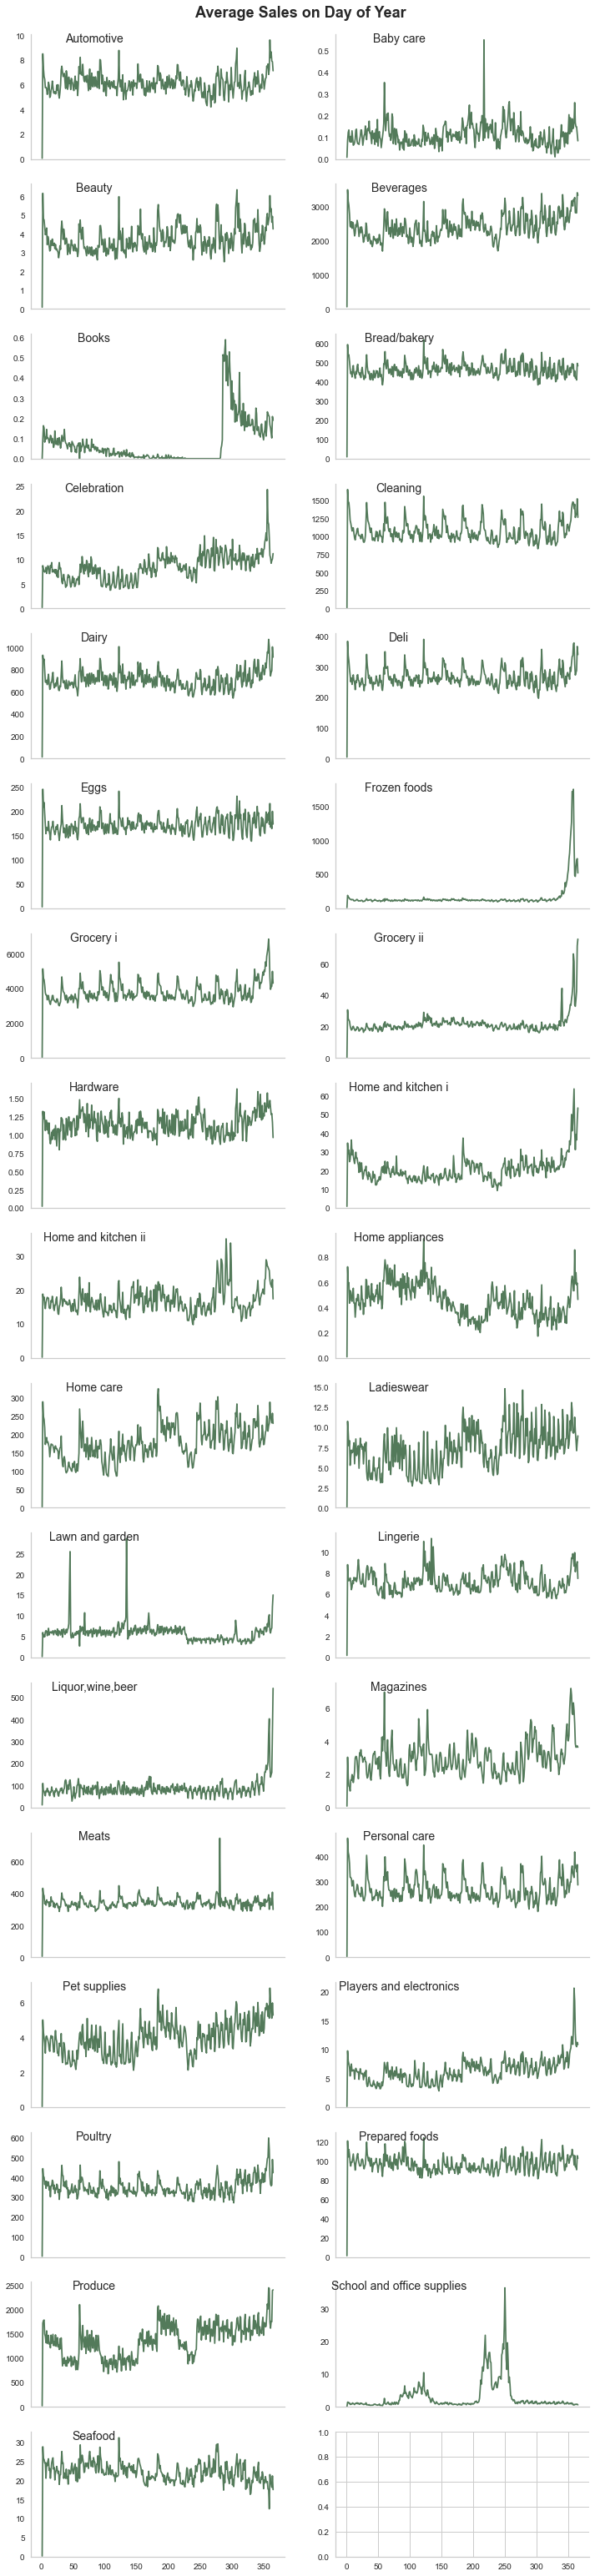

In [12]:
df_family = train.loc[:,['date','family','sales']].copy()
df_family['date'] = pd.to_datetime(df_family['date'])
df_family = df_family.groupby(
    ['family',(df_family.date.dt.month),(df_family.date.dt.day)]
    ).mean()

# Create Figure and subplots
sns.set_style('whitegrid')
fig, axs = plt.subplots(17, 2, figsize=(12,48), sharex=True)
sns.despine(fig)
fig.suptitle('Average Sales on Day of Year', fontsize=18, fontweight=600, y=1.01)
fig.subplots_adjust(top=1)

# Plots
plot=0
for family in train.family.unique():
    ax=axs[floor(plot/2), plot%2]
    sns.lineplot(
        data=df_family.loc[family],         
        x=range(1,366),
        y=df_family.loc[family]['sales'],
        color='#537A5A',
        ax=ax)
    ax.set(
        ylabel=None,
        xlabel=None,
        ylim=(0,None))
    ax.set_title(
        family.capitalize(),
        y=0.9,
        x=0.25,
        fontdict={'size':14,'weight':500})
    ax.grid(False)
    plot += 1

Most spikes in sales by product occur in December due to the holidays. The feature <i>is_december</i>, previously mentioned, will help forecast these spikes.

The last feature to be explored before moving on to Time Series Analysis is the pay day of the public sector, which occurs on the 15th and last day of each month. Does this have any correlation with store sales? Does the week of pay day have a stronger correlation than the exact day, as people may not go to the store immediately? The answer to this will be considered when forecasting.

<AxesSubplot:>

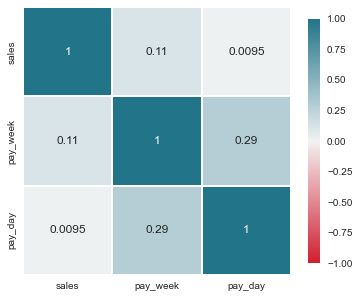

In [13]:
df_daily.date = pd.to_datetime(df_daily['date'])
df_daily['day_of_month'] = df_daily.date.dt.day.astype('int')
df_daily['pay_day'] = df_daily['date'].apply(
    lambda x: (x.is_month_end)
        or (x.day==15)
    ).astype('int')
df_daily['pay_week'] = df_daily['date'].apply(
    lambda x: (x.is_month_end)
        or (x.day in range(15,22))
        or (x.day in range(1,7))
    ).astype('int')

plt.figure(figsize=(6,6))
sns.heatmap(
    df_daily[['sales','pay_week','pay_day']].corr(), 
    cmap = sns.diverging_palette(10, 220, as_cmap=True, l=45, s=90), 
    annot=True, 
    square=True,
    vmin=-1,
    vmax=1,
    cbar_kws={'shrink':.75 },
    linewidths=0.08, linecolor='white')

<h1>2. Time Series Analysis</h1>

<h3>Autocorrelation</h3>

"The **autocorrelation function (ACF)** shows the value of the correlation coefficient between the series and its lagged values. The ACF considers all of the components of the time series while finding the correlations. That is why it’s known as the complete auto-correlation plot.

In contrast, the **partial autocorrelation function (PACF)** looks at the correlation between the residuals (the remainder after removing the effects explained by the previous lags) and the following lag value. This way, we effectively remove the already found variations before we find the next correlation. In practice, a high partial correlation indicates that there is some information in the residual that can be modeled by the next lag. So we might consider keeping that lag as a feature in our model."

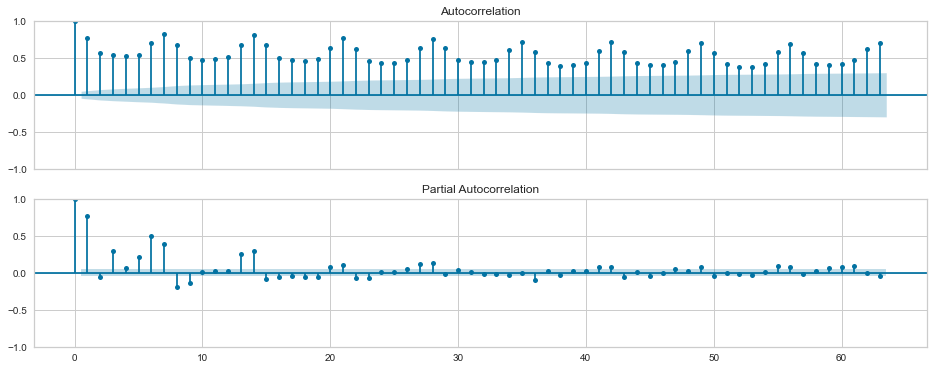

In [14]:
fig, ax = plt.subplots(2, sharex=True, figsize=(16,6))
plot_acf(df_daily['sales'], lags=63, ax=ax[0])
plot_pacf(df_daily['sales'], ax=ax[1], lags=63, method='ywm');

<h3>Seasonality</h3>

Time series can be broken into a additive or multiplicitive combination of the following components:
* level — the average value of the series
* trend — an increasing/decreasing pattern in the series
* seasonality — a repeating short-term cycle in the series
* noise — unexplainable variation/irreducible error

"A rule of thumb for selecting the right model is to see in our plot if the trend and seasonal variation are relatively constant over time, in other words, linear. If yes, then we will select the Additive model. Otherwise, if the trend and seasonal variation increase or decrease over time then we use the Multiplicative model." Or it may be said "If the seasonality and residuals are independent of the trend in the plotted time series, we use an additive model to decompose the data."

There are multiple ways to determine the seasonal period, but a basic and effective approach is to observe the peak of autocorrelation patterns. In the above correlation plot, it is clear the seasonal period for daily sales is 7 days. Additionally, a <b>periodogram</b> may be used to identify the most dominant frequencies/periods in time series analysis and signal processing  (Fourier Analysis). A periodogram below emphasizes the dominance of the weekly seasonality in this sales data.

In [15]:
def plot_periodogram(ts, detrend='linear', ax=None):
    
    fs = pd.Timedelta('1Y') / pd.Timedelta('1D')
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,4))
    ax.step(freqencies, spectrum, color='#17869E')
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            'Annual (1)',
            'Semiannual (2)',
            'Quarterly (4)',
            'Bimonthly (6)',
            'Monthly (12)',
            'Biweekly (26)',
            'Weekly (52)',
            'Semiweekly (104)',
        ],
        rotation=30)
    ax.set_title('Periodogram', fontdict={'size':14,'weight':'bold'})
    ax.ticklabel_format(axis='y', scilimits=(0, 0))
    ax.set_ylabel('Power Spectral Density')
    ax.set_title('Periodogram')
    
    return ax

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Power Spectral Density'>

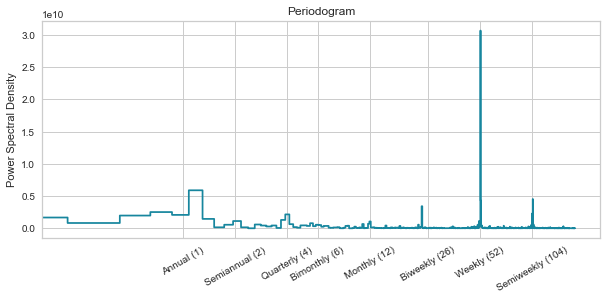

In [16]:
plot_periodogram(df_daily.sales)

In [17]:
def series_decomp(y, model, period):   
    """
    Plot time series decomposition--observations, trend, seasonality, and residuals
    
    y - time series target variable
    model - additive or multiplicative decomposition model\n
    period - the length of a single season
    """
    decomp = seasonal_decompose(y, model=model, period=period) 

    fig = make_subplots(
        rows=4,
        cols=1,
        specs=[
            [{'type': 'scatter'}],
            [{'type': 'scatter'}],
            [{'type': 'scatter'}],
            [{'type': 'scatter'}]],
        subplot_titles=('Observed', 'Trend', 'Seasonality', 'Residual'),
        shared_xaxes=True)
    fig.update_layout(showlegend=False, template='plotly_white')
    
    decomp_chart = [decomp.observed, decomp.trend, decomp.seasonal, decomp.resid]
    name = ['Observed', 'Trend', 'Seasonal', 'Residual']
    color = ['#17869E','#008fd5','#008fd5','#008fd5']
    
    for i in range(0,4):
        fig.add_trace(
            go.Scatter(
                x=decomp_chart[i].index,
                y=decomp_chart[i].values,
                mode='lines',
                name=name[i],
                marker_color=color[i]),
            row=i+1,
            col=1)
    
    return fig

# Alternatively, create a quick simple plot with seasonal_decompose( ... ).plot()

In [18]:
series_decomp(df_daily['sales'],'additive',7)

<h3>Stationarity</h3>

A process is <i>Stationary</i> if its statistical properties remain constant over time. Distributions depend only on differences in time, not location in time. In other words...
* Mean is constant and not time dependent
* Variance is constant and not time dependent ("Homoscedasticity")
* Covariance is constant and not time dpendent

Therefore, it is clear any series with trend and/or seasonality is not stationary. This is problematic because times series models intend to predict such statistical properties--without stationarity, future predictions will be poor. As expected, most series worth analyzing are not stationary. Stationarity can be checked a few ways:
* Visually: The existence of a trend/seasonilty may be apparent by plotting data
* Basic Statistics: Compare statistical properties between partitions of the time series
* Statistical Test: Augmented Dickey Fuller Test

<h4>Dickey Fuller Test:</h4>

Consider the series $x_{t}=ρx_{t-1}+e_{t}$, where $x_{0}=0$ and $e_{t}$ is a random variable with standard Gaussian distribution (mean of 0 and standard deviation of 1). Here we have ρ (rho) determining how much $x_{t}$ is influenced by the previous term $x_{t-1}$.

Subtracting $x_{t-1}$ from both sides leads to $x_{t}-x_{t-1}=(ρ-1)x_{t-1}+e_{t}$. It is now clear that when $ρ=1$, we have $x_{t}-x_{t-1}=e_{t}$ (the value of $x_{t}-x_{t-1}$ is known as the first difference). Since $e_{t}$ is a random variable, the series is a random walk process when $ρ=1$ and is thus non-stationary, unlike for $0≤ρ<1$. The Dickey Fuller Test checks for the presence of this <i>unit root</i> ($ρ=1$) to determine a series' stationarity. The first difference isn't always sufficient to determine stationarity, so <i>The Augmented Dickey Fuller Test</i> utilizes higher order differences. 

The <i>null hypothesis</i> $H_{0}$ is the time series has a unit root (non-stationary). $H_{0}$ may be rejected on the basis of the calculated <i>p-value</i> or if the ADF test statistic is less than (more negative) the critical value.

In [19]:
def adfplot(y, lags=None, figsize=(10, 5), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation.
        
        This will also be used for the mean and standard deviation rolling window.
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        result = sm.tsa.stattools.adfuller(y)
        adf = result[0]
        p_value = result[1]
        crit_1 = result[4]['1%']
        crit_5 = result[4]['5%']
        crit_10 = result[4]['10%']
        
        ts_ax.set_title(
            f'Time Series Analysis Plots\n'
            + f'Critical Values 1%: {crit_1:0.3f}'
            + f'5%: {crit_5:0.3f}'
            + f'10%: {crit_10:0.3f}\n'
            + f'p = {p_value:0.5f} | adf = {adf}', 
            fontsize=12)
        
        ts_ax.plot(y)
        ts_ax.plot(y.rolling(lags).mean(), color='#fd722f')
        ts_ax.plot(y.rolling(lags).std(), color='#98441c')

        plot_acf(y, lags=lags, ax=acf_ax)
        plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')
        plt.tight_layout()
        ##132C33

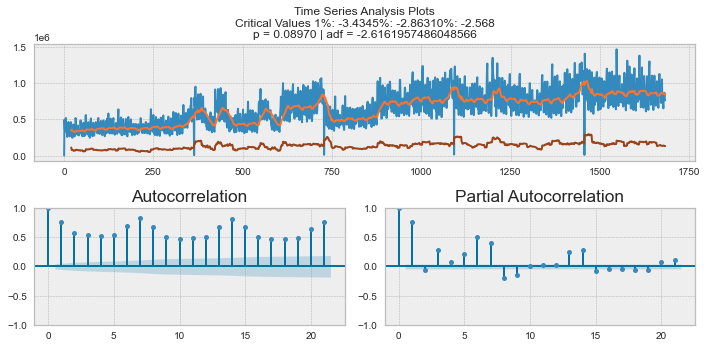

In [20]:
adfplot(y=df_daily['sales'],lags=21)

Since the data is non-stationary, it must be transformed before using any model that requires stationarity.
* <b>Transformation:</b> e.g. logarithmic or square root for non-constant variance, Box-Cox
* <b>Differencing:</b> e.g. Remove trend or seasonality, take first differences
can be adjusted using a variety of approaches: order differences, removing trend or seasonality, smoothing, and transformations such as Box-Cox or logarithmic. Differencing adjusts for non-constant mean, not for non-constant variance.

First, let's remove compensate for the linear trend (seen in the time series decomposition) by taking the first difference.

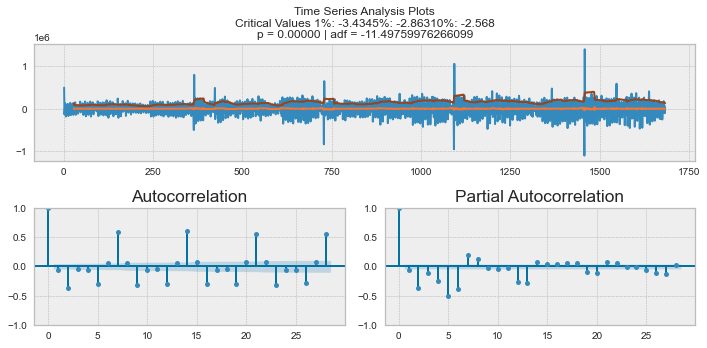

In [21]:
sales_dif = df_daily.sales - df_daily.sales.shift(1)
# First row will be NaN since first difference cannot be calculated, drop NaN
sales_dif.dropna(inplace=True)
adfplot(y=sales_dif,lags=28)

First differences have vastly improved the stability of the mean and the Dickey Fuller Test rejects the null hypothesis--i.e. the series is stationary. However, there is still apparent seasonality seen in the autocorrelation. The high correlation every 7 lags shows the presence of weekly seasonality. This will now be removed with by subtracting the seventh lag.

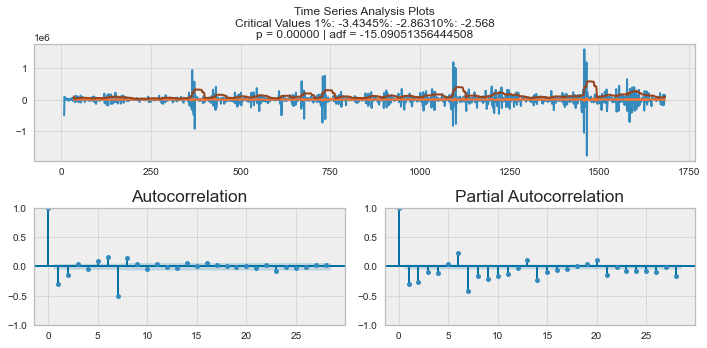

In [22]:
sales_dif = sales_dif - sales_dif.shift(7)
sales_dif.dropna(inplace=True)
adfplot(y=sales_dif,lags=28)

<h1>4. Forecasting Models</h1>

<h4>Stochastic Models</h4>

* Naive Approach
    <p style="padding-left: 10px;">$\hat{y}_{t}=\hat{y}_{t-1}$</p><br>
* Autoregression 
    
    <p style="padding-left: 10px;">
    $AR(p)$ forecasts the target variable using a linear combination of previous observations. The term autoregression indicates that it is a regression of the variable against itself $y_{t}=\beta_{0}+\beta_{1}y_{t-1}+...+\beta_{p}y_{t-p}+\epsilon_{t}$. Autoregression is a <i>long memory model</i> because the first observation affects all others, even though its affect may greatly decrease through observations. A good starting place to determine <i>p</i> (maximum lag), is utilizing the PACF plot to identify biggest significant lag after which most other lags become insignificant.
    </p><br>
    
* Moving Average
    
    <p style="padding-left: 10px;"> $MA(q)$ forecasts the target variable using a linear combination of previous errors. $y_{t}=\beta_{0}+\beta_{1}\epsilon_{t-1}+...+\epsilon_{q}y_{t-q}+\epsilon_{t}$. Moving average is a <i>short memory model</i> because the error previous to $q$ lags does not affect forecasting of $y_t$. This is why <i>stationarity</i> is important to the <i>MA</i> model--the dependence of previous observations decline (disappear) over time. A good starting place to determine <i>q</i> (maximum lag), is utilizing the ACF plot the same way <i>AR</i> used PACF.
    Note: it can easily be shown that $AR(1)=MA(∞)$ given autoregression's recursivity.
    </p><br>
    
* ARIMA
    
     <p style="padding-left: 10px;">$ARMA(p,q)=AR(p)+MA(q)$ Common techniques for choose <i>p</i> and <i>q</i> include MINIC, SCAN, and ESACF. $ARMA$ can be used with a stationary series. If a series is non-stationary, the $I$ in <i>ARIMA</i> stands for <i>integrated</i>, which adds a parameter <i>d</i> for the order of differencing used to create stationarity and results in $ARIMA(p,d,q)$.
    </p><br>
    
* SARIMA
    <p style="padding-left: 10px;">$SAIRMA(p,d,q)(P,D,Q,s)$ expands the ARIMA model further by considering seasonality.
    
    $s$  - equal to the season period length of the series<br>
    $P$  - order of autoregression for the seasonal component. This can be derived from PACF just like $p$. However, $P$ is the number of seasons. For example, if a season is 12 lags, then $P=2$ is equivalent to 24 lags.<br>
    $Q$  - order of moving average for the seasonal component. This can be derived from PACF just like $q$ and indicates the number of seasons like $P$.<br>
    $D$  - order of seasonal integration. This can equal 1 or 0, depending on whether or not seasonal differeces were applied.
    </p>
* Exponential Smoothing
* Prophet

<h4>Deep Learning Models</h4>

* LSTM
* GRU

Other common Machine Learning models
* Regression
* Random Forest
* etc.

<h2>4.1 SARIMA Model</h2>

Some details of SARIMA are explained above but as a brief summary, SARIMA is a linear regression model that uses its own lags as features. <a href="https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html">sm.tsa.statespace.SARIMAX</a> will be used to create the model. 

d, D, and s are already determined, but the other SARIMA parameters will be optimized through a parameter gridsearch.

* <i>p</i> is likely 7 since it is the last significant lag on the PACF, after which, most others are not significant.
* <i>d</i> equals 1 because the first difference was taken to achieve stationarity
* <i>q</i> is also likely around 7 as seen on the ACF
* <i>P</i> might be 1, since 7th lag (1 season) remains significant on the PACF
* <i>D</i> equals 1 because seasonal differencing was performed
* <i>Q</i> is probably 1. The 7th lag on ACF is significant while the 14th is not.
* <i>s</i> equals 7 because of weekly seasonality

The best model parameters will be determined using the <a href="https://en.wikipedia.org/wiki/Akaike_information_criterion">Akaike Information Criterion</a> (AIC). This criterion is concerned with goodness of fit and is calculated using the sum of squared errors and the number of parameters used. An alternative metric is the Bayesian Information Criterion (BIC). These metrics are for model selection--they do not indicate the accuracy/effectiveness of the model.

In [23]:
def optimizeSARIMA(y, parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        y - Observed time series
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """  
    results = []
    best_aic = float('inf')

    for param in parameters_list:
        # we need try-except because with combinations model fails to converge
        try:
            model=SARIMAX(
                y,
                order=(param[0], d, param[1]), 
                seasonal_order=(param[2], D, param[3], s)
            ).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results, columns=['parameters', 'AIC'])
    # sorting in ascending order -- lower AIC is better
    result_table = result_table.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_table, best_model

In [24]:
# Train/validation split with 0.2 validation data
train_index = floor(len(df_daily)/5)*4
val_index = len(df_daily)

# Set parameters for gridsearch 
# (repeated multiple times and narrowed to these values)
p = [7,8,14]
d = 1 
q = [7,8,14]
P = range(0, 2)
D = 1 
Q = range(0, 2)
s = 7

# Create list with all the possible combinations of p, q, P, Q
parameters = product(p, q, P, Q)

parameters_list=[]
for p in parameters:
    parameters_list.append(p)

# Optimize SARIMA
sarima_table, sarima_model = optimizeSARIMA(
    df_daily.loc[:train_index,'sales'],
    parameters_list,
    d, D, s)

In [25]:
print(sarima_model.summary())
sarima_table

                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                 1345
Model:             SARIMAX(8, 1, 14)x(0, 1, [], 7)   Log Likelihood              -17084.440
Date:                             Thu, 21 Jul 2022   AIC                          34214.881
Time:                                     02:52:19   BIC                          34334.439
Sample:                                          0   HQIC                         34259.677
                                            - 1345                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3629      0.590     -0.615      0.539      -1.520       0.794
ar.L2          0.4638      

parameters           AIC
0   (8, 14, 0, 0)  34214.880552
1  (14, 14, 0, 0)  34226.371589
2   (7, 14, 0, 0)  34243.345756
3   (14, 7, 0, 0)  34245.490602
4   (14, 8, 0, 0)  34247.747544
5    (8, 8, 0, 0)  34255.586424
6    (7, 8, 0, 0)  34262.030735
7    (8, 7, 0, 0)  34278.232826
8    (7, 7, 0, 0)  34286.693703

In [26]:
sarima_predict = sarima_model.predict(start=train_index+1, end=val_index-1)
sarima_msle = mean_squared_log_error(
    df_daily.loc[train_index+1:val_index, 'sales'],
    list(sarima_predict))
sarima_rmse = np.sqrt(mean_squared_error(
    df_daily.loc[train_index+1:val_index, 'sales'],
    list(sarima_predict)))

In [27]:
trace0 = go.Scatter(
    x=df_daily.loc[:train_index, 'date'],
    y=df_daily.loc[:train_index, 'sales'],
    mode='lines',
    name='Train',
    marker_color='#17869E')

trace1 = go.Scatter(
    x=df_daily.loc[train_index+1:val_index, 'date'],
    y=df_daily.loc[train_index+1:val_index, 'sales'],
    mode='lines',
    name='Validation',
    marker_color='#008fd5')

trace2 = go.Scatter(
    x=df_daily.loc[train_index+1:val_index, 'date'],
    y=sarima_predict,
    mode='lines',
    name='SARIMA Prediction',
    marker_color='#fc4f30')

layout = go.Layout(
    width=775,
    height=375,
    title=f'''SARIMA Model <br>
        <sup>RMSE: {sarima_rmse:0.2f} <b>|</b> MSLE: {sarima_msle:0.4f}</sup>''',
    title_x=0.45,
    template='plotly_white',
    hovermode='x unified')

go.Figure(data=[trace0, trace1, trace2], layout=layout)

# An alternative method is passing multiple variables for y in plotly express 

The SARIMA model is proving to be an effective model. However, it is desired for the model to forecast sales based on store number and product family--with 54 stores and 33 families, this would require 1,782 separate SARIMA models. If store and/or family could be utilized as a predictor, then far fewer models would be required. This leads to exploring other Linear regression models.

<h2>4.2 Linear Regression Model</h2>

<h4>4.2.1 Feature Engineering</h4>

A regression model needs features, so additional data will be included, such as oil prices, that were not included in the previous SARIMA model. There are also several ways one may extract features from one-dimensional data (in this case, the daily sales data). Using store_nbr and/or product family as features will also enable predictions to be made with fewer models than SARIMA.

* Lags of time series
* Window statistics:
    * Max/min value of series in a window
    * Average/median value in a window
    * Window variance
    * etc.
* Date and time features:
    * Minute of an hour, hour of a day, day of the week, and so on
    * Represent Holiday or event dates as a boolean features
* Forecasts from other models (note that speed of prediction can be lost this way)

Many features will be included/created in the following cells. Regularization techniques will later be used to eliminate those that risk overfitting the date. Note that in real practice, oil price would not be known in advanced--this feature would need to be neglected or forecasted.

Caution must be taken when encoding categorical features. Ordinal variables may seem appropriate for time-dependent features, but this is not always the case. In order to understand this, it is effective to consider the linear regression model $\hat{y}=\beta_{0}+\beta_{1}x_{1}+...+\beta_{p}x_{p}$ with an ordinal encoded variable <i>day_of_week</i> compared to a model with one-hot/nominal/dummy variables for each day of the week. For our data, it is more appropriate here to use latter option.

<h4>Features to be created:</h4>

* year
   * 2013 will be year 0, 2014 will be year 1, and so on. This will better model the overall year-to-year trend in the context of regression $\hat{y}=\beta_{0}+\beta_{1}x_{1}+...+\beta_{p}x_{p}$. 
* is_december
    * When it comes to month-to-month sales, it was previously observed that sales only increase consistently and reliably during the month of December.
* Day of week dummy variables
    * It was previously observed that the difference in sales on different days of the week was quite consistent from year-to-year. For this reason each individual day will have a dummy variable (drop one for multi-colinearity) instead of a simpler <i>is_weekend</i> feature. Additionally, ordinal variables are not appropriate since sales don't have a steady increase or decrease throughout the week.
* pay_week
    * Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. The pay_week feature indicates if the public sector pay day occured within the previous week.
* Product family dummy variables
* Store dummy variables
* Weekly moving average of oil prices
* National Holidays, work days, etc. from Holidays_Events.csv
* A 7 day lag of sales, grouped by store and product family.

In [28]:
# Create calendar for all non-store data (e.g. time dependant, oil price, holidays)
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31'))

# Oil moving average
oil = pd.read_csv(
    'oil.csv',
    parse_dates = ['date'],
    infer_datetime_format = True,
    index_col = 'date')

calendar = calendar.join(oil['dcoilwtico'])
calendar['dcoilwtico'].fillna(method = 'ffill', inplace = True)
calendar['oil_ma'] = calendar['dcoilwtico'].rolling(7).mean()

# Holidays and events
holidays = pd.read_csv(
    'holidays_events.csv',
    parse_dates = ['date'], infer_datetime_format = True,
    index_col = 'date')

# Official transfer for new years eve holiday, but it didn't affect sales
holidays.loc[297, 'transferred'] = False
# Only national holidays for now
holidays = holidays[holidays.locale == 'National']
# Remove duplicate holiday on same date
holidays = holidays.groupby(holidays.index).first()

calendar['dofw'] = calendar.index.dayofweek 
calendar = calendar.join(holidays)

# workday column
calendar['wd'] = 1
# weekend = not work day
calendar.loc[calendar.dofw > 4, 'wd'] = 0   
# work day event = work day (can occur on weekend)
calendar.loc[calendar.type == 'Work Day', 'wd'] = 1
# Transfer event =  not work day
calendar.loc[calendar.type == 'Transfer', 'wd'] = 0
# Transfer event =  not  work day
calendar.loc[calendar.type == 'Bridge', 'wd'] = 0
# not transferred holiday = not work day
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = 0

calendar = pd.get_dummies(calendar, columns = ['dofw'], drop_first = True)
calendar = pd.get_dummies(calendar, columns = ['type'])

calendar.drop(
    ['locale', 'locale_name', 'description', 'transferred', 'dcoilwtico'],
    axis=1,
    inplace=True)

# Additional features could be created by matching the local/region to the appropriate store

In [29]:
def get_family_dummies(df):
    """
    Returns a dataframe with dummy variables for the product family
    """
    df = pd.get_dummies(df, columns = ['family'], drop_first = True)
    
    return df


def get_store_dummies(df):
    """
    Returns a dataframe with dummy variables for the store
    """
    df = pd.get_dummies(df, columns = ['store_nbr'], drop_first = True)   
    df.columns = df.columns.astype(str) # Column names not accept if integers
    
    return df

In [30]:
# Time Related Features
def create_is_december(df):
    """
    Adds a column to dataframe indicating if the month is December
    """
    df['date'] = pd.to_datetime(df['date'])
    df['is_december'] = df['date'].dt.month==12
    df['is_december'] = df['is_december'].astype(int)

    
def create_is_payweek(df):
    """
    Creates a pay_week column to indicate if it has been less than 
    a week since the most recent pay day.
    """
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_month'] = df.date.dt.day.astype('int')
    df['pay_week'] = df['date'].apply(
        lambda x: (x.is_month_end) or (x.day in range(15,22)) or (x.day in range(1,7))
    ).astype('int')
    df.drop('day_of_month', axis=1, inplace=True)

<h4>Data cleaning</h4>



New Years Day is the only day when stores consistently close and have zeros sales--only one or two store remains open on this day. All dates with zero sales from any particular store appear to be arbitrary or an extended period of time when the store data is missing/the store was not yet open. All of those zero sales dates will be removed from the training dataset. Stores will generally know in advanced if they will be closed on any given day, so a real-time model would be able to take this into account.

In [31]:
def remove_stores_closed(df):
    """
    Removes data from when a particular stores was not yet open, 
    arbitrary closed, or missing data
    
    returns: dataframe
    """
    df = pd.merge(
        df, stores_closed[['store_nbr','date']],
        on=['store_nbr','date'],
        how='outer',
        indicator=True)
    df = df[df['_merge']=='left_only']
    df.drop('_merge', axis=1, inplace=True)
    return df


def remove_zero_sales(df):
    """
    Removes data for product families that a particular store does not sell and 
    places it into zero_sales_data dataframe. 
    
    returns: dataframe, zero_sales_data
    """
    zero_sales_data = zero_sales.reset_index()
    df = pd.merge(
        df, zero_sales_data[['store_nbr','family']],
        on=['store_nbr','family'],
        how='outer',
        indicator=True)
    zero_sales_data = df.loc[df['_merge']=='both'].copy()
    zero_sales_data.drop('_merge', axis=1, inplace=True) 
    zero_sales_data.loc[:,'sales'] = 0
    df = df.loc[df['_merge']=='left_only'].copy()
    df.drop('_merge', axis=1, inplace=True)  
    return df, zero_sales_data

In [32]:
def prepare_regression_data(df, training=True, by=None):
    """
    Applies all the feature engineering functions and data cleaning to the dataframe
    
    df: Dataframe for forecasting model
    training: Indicates if df is for training a model. 
        This will remove the data from when certain stores were 
        not yet open (stores_closed dataframe)
    by: Used if models will be created by family or store. 
        Will omit creating dummy variables if 'family' or 'store' is passed
     
    Returns: df, zero_sales_data
    """
    # Sort by date for appropriate Time Series CV split
    df.sort_values('date', inplace=True)    

    if training:
        df['lag7'] = df.groupby(['store_nbr','family']).shift(7).sales

    df = remove_stores_closed(df)

    df, zero_sales_data = remove_zero_sales(df) 
    
    # Dummy Variables
    if by != 'family':
        df = get_family_dummies(df)
    if by != 'store':
        df = get_store_dummies(df)
    
    # Time-based features
    create_is_december(df)
    create_is_payweek(df)
    df.date = pd.to_datetime(df.date)
    calendar_merge = calendar.reset_index().rename(columns={'index': 'date'})
    df = pd.merge(
        left = df,
        right = calendar_merge,
        how = 'left',
        on = 'date')
    df['year'] = df.date.dt.year - 2013

    # Clean up
    # Reposition to match future columns of forecast data
    if training: df['lag7'] = df.pop('lag7')
    # Drop 1 week of data due to oil moving average and lag7 NaN
    df.dropna(inplace=True)
  
    return df, zero_sales_data

<h4> 4.2.2 Train and Tune Regression Model</h4>

There are many features and they may not all be effective with training a regression model. For this reason, there will be a comparison between linear, lasso, elastic net, and ridge regression as a method of regularization. These regularization techniques are a means to reduce overfitting the forecasting model.

<b>Lasso Regression</b>

Lasso stands for Least Absolute Shrinkage and Selector Operator. Lasso assigns a penalty to the coefficients in the linear model using the formula below. This is called <i>shrinkage</i>, where data values are shrunk to a central point such as a mean.

<p style="padding-left: 20px;">Lasso = Sum of Error + Sum of the absolute value of coefficients<br>
$L = ∑( Ŷ_{i}– Y_{i})² + λ∑ |β|$</p>

Lasso adds a penalty to coefficients the model overemphasizes. This reduces the degree of overfitting that occurs within the model. Since Lasso regression aims to minimize the equation above, an increase in any the weight of any coefficient β, must be counteracted by a sufficient decrease in residuals.

The value of lambda (alpha in the SkLearn models) determines the severity of the penalty for the coefficients. This penalty reduces the value of many coefficients to zero, all of which are eliminated. Lasso regression allows for the weight of one or more variables to be reduced to 0, at which point the variable will not contribute to the model.

Lasso does not work well with multicollinearity--occurring when some of the dependent variables are correlated with each other. Lasso might randomly choose one of the multicollinear variables without understanding the context. Such an action might eliminate relevant variables.

<b>Ridge Regression</b>

Like Lasso, Ridge Regression adds a penalty to coefficients the model overemphasizes. Unlike lasso, Ridge Regression will not shrink coefficients to zero, instead coefficients approach zero asymptotically. Therefore, this model does not eliminate coefficients even if the variables are irrelevant, which can be particularly negative if there are more variables than observations.

<p style="padding-left: 20px;">Ridge = Sum of Error + Sum of the squares of coefficients<br>
$R = ∑( Ŷi– Yi)² + λ∑ β²$</p>

<b>Elastic Net</b>

Elastic Net combines characteristics of both lasso and ridge, which reduces the impact of different variables without eliminating them. Elastic Net includes Ridge penalty + Lasso penalty.

<p style="padding-left: 20px;">$Enet = ∑( Ŷ_{i}– Y_{i})² + λ∑ β² + λ∑ |β|$</p>

In [33]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_reg, zero_sales_data = prepare_regression_data(train)

In [34]:
scaler = StandardScaler()
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
enet = ElasticNet(0.5)

lr_rmse = []
ridge_rmse = []
lasso_rmse = []
enet_rmse = []

X = train_reg.drop(['sales','id','date'],axis=1)
y = train_reg.loc[:,'sales']

# 4 CV splits so each split is almost 1 year
tscv = TimeSeriesSplit(n_splits=4)

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Standardize
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    # Linear Regression
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val).clip(0.)
    lr_rmse.append(np.sqrt(mean_squared_error(y_val,y_pred)))
    
    # Ridge Regression
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_val).clip(0.)
    ridge_rmse.append(np.sqrt(mean_squared_error(y_val,y_pred)))
    
    # Elatic Net Regression
    enet.fit(X_train, y_train)
    y_pred = enet.predict(X_val).clip(0.)
    enet_rmse.append(np.sqrt(mean_squared_error(y_val,y_pred)))
    
    # Lasso Regression
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_val).clip(0.)
    lasso_rmse.append(np.sqrt(mean_squared_error(y_val,y_pred)))
    
print(f'Average Lr RMSE: {sum(lr_rmse)/len(lr_rmse):0.4f}')
print(f'Average Lasso RMSE: {sum(lasso_rmse)/len(lasso_rmse):0.4f}')
print(f'Average Elastic Net RMSE: {sum(enet_rmse)/len(enet_rmse):0.4f}')
print(f'Average Ridge RMSE: {sum(ridge_rmse)/len(ridge_rmse):0.4f}')

Average Lr RMSE: 27565337503376.0938
Average Lasso RMSE: 362.7383
Average Elastic Net RMSE: 399.9128
Average Ridge RMSE: 363.2517


The Linear Regression had an awfully large error, so there was certainly a great deal of overfitting when using all features. The other models, however, showed phenomenal improvement. The models likely improved as more data was used, so below we will also check the RMSE for the last time series cross validation split (that which uses the most data) as well as the top weighted features for each model.

Linear last split RMSE: 2727246241140.8877
Lasso last split RMSE: 340.60763089061885
Elastic Net last split RMSE: 340.39617507182606
Ridge last split RMSE: 339.7938279318746


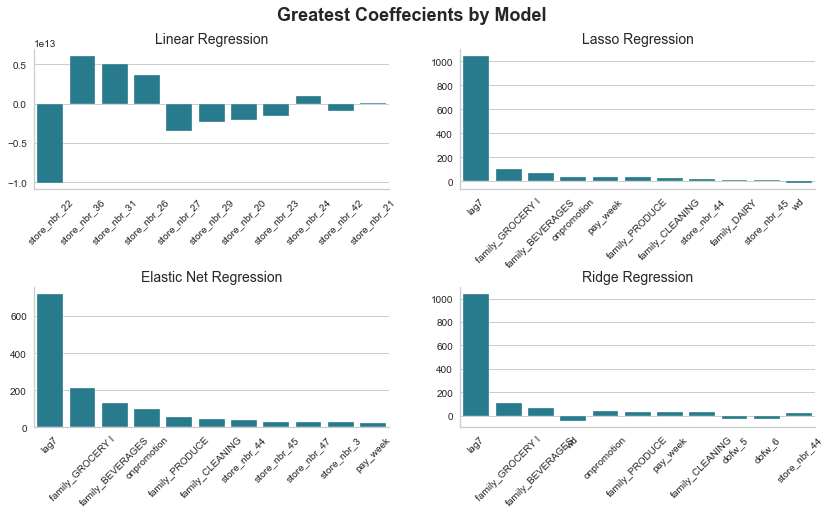

In [35]:
print(f'Linear last split RMSE: {lr_rmse[-1]}')
print(f'Lasso last split RMSE: {lasso_rmse[-1]}')
print(f'Elastic Net last split RMSE: {enet_rmse[-1]}')
print(f'Ridge last split RMSE: {ridge_rmse[-1]}')

lr_coef = pd.DataFrame(lr.coef_, X.columns)
lr_coef.columns = ['coef']
lr_coef['abs'] = lr_coef.coef.apply(np.abs)
lr_coef = lr_coef.sort_values('abs', ascending=False).drop(['abs'], axis=1)

lasso_coef = pd.DataFrame(lasso.coef_, X.columns)
lasso_coef.columns = ['coef']
lasso_coef['abs'] = lasso_coef.coef.apply(np.abs)
lasso_coef = lasso_coef.sort_values('abs', ascending=False).drop(['abs'], axis=1)

enet_coef = pd.DataFrame(enet.coef_, X.columns)
enet_coef.columns = ['coef']
enet_coef['abs'] = enet_coef.coef.apply(np.abs)
enet_coef = enet_coef.sort_values('abs', ascending=False).drop(['abs'], axis=1)

ridge_coef = pd.DataFrame(ridge.coef_, X.columns)
ridge_coef.columns = ['coef']
ridge_coef['abs'] = ridge_coef.coef.apply(np.abs)
ridge_coef = ridge_coef.sort_values('abs', ascending=False).drop(['abs'], axis=1)

# Create Figure and subplots
sns.set_style('whitegrid')
fig, axs = plt.subplots(2, 2, figsize=(14,6)) # 4 models in total
sns.despine(fig)
fig.suptitle('Greatest Coeffecients by Model', fontsize=18, fontweight=600, y=1.1)
fig.subplots_adjust(top=1)

# Plot Coefficients
plot = 0
title = [
    'Linear Regression',
    'Lasso Regression',
    'Elastic Net Regression',
    'Ridge Regression']

for model in [lr_coef, lasso_coef, enet_coef, ridge_coef]:
    ax=axs[floor(plot/2), plot%2]
    sns.barplot(
        data=model,         
        x=model.index[:11],
        y=model.coef[:11],
        color='#17869E',
        ax=ax)
    ax.set(
        ylabel=None,
        xlabel=None)
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(
        title[plot],
        fontdict={'size':14,'weight':500})
    plot += 1
    
plt.subplots_adjust(hspace=0.7)

Keep in mind the RMSE errors are for each individual date, store, and product family. Therefore, there's plenty of room for improvement and clearly regularization is necessary with this set of variables (i.e. linear regression performance is unacceptable). Next, a model will be created for each individual product family. These were some of the most influential features on the previous models and will allow for better performance within each family. Lasso regression will be utilized and the alpha parameter will be optimized for each model using a gridsearch.

RMSE will be tricky to interpret since different product families have a very different range of sales. To help with the readability of evaluation metrics, Mean Squared Log Error (MSLE) will also be calculated. MSLE can be understood as a ratio (see below) between the actual and predicted values. Since the sales of different product familes have very different ranges, the ratio attribute of MSLE can make it easier to compare performance of different models.

$L(y,\hat{y})=\frac{1}{N}\sum_{i=0}^{N}\left(log(y_i+1)-log(\hat{y}_i+1)\right)^2=\frac{1}{N}\sum_{i=0}^{N}\left(log\left(\frac{y_i+1}{\hat{y}_i+1}\right)\right)^2$<br>

In [36]:
train_family, zero_sales_data = prepare_regression_data(train, by='family')

In [37]:
# Create a list of alphas
alphas = np.logspace(-3, 0.5, 25)

# Track evaluation and best alpha for each family
lasso_eval = pd.DataFrame(columns=['family', 'RMSE', 'MSLE', 'alpha'])
lasso_eval['family'] = train_family.family.unique()
lasso_eval[['RMSE', 'MSLE', 'alpha']] = [np.inf, 0, 0]

# Train/Validation index. Equivalent to last split of the previous TSCV
train_index = floor(len(train_family)/5)*4
val_index = len(train_family)

for alpha in alphas:

    lasso = Lasso(alpha=alpha)

    X = train_family.drop(['sales','date', 'id'],axis=1)
    y = train_family.loc[:,['family','sales']]

    X_train, X_val = X.iloc[0:train_index], X.iloc[train_index:val_index]
    y_train, y_val = y.iloc[0:train_index], y.iloc[train_index:val_index]

    for fam in train_family.family.unique():

        # Training data
        Xt = X_train.loc[X_train.family==fam].drop('family', axis=1)
        Xt = scaler.fit_transform(Xt)
        yt = y_train.loc[y_train.family==fam].drop('family', axis=1)

        # Validation data
        Xv = X_val.loc[X_val.family==fam].drop('family', axis=1)
        Xv = scaler.transform(Xv)
        yv = y_val.loc[y_val.family==fam].drop('family', axis=1)

        # Lasso Regression
        lasso.fit(Xt, yt)
        y_pred = lasso.predict(Xv).clip(0.)

        # Evaluate
        rmse = np.sqrt(mean_squared_error(yv, y_pred))
        msle = mean_squared_log_error(yv, y_pred)

        if rmse < lasso_eval.loc[lasso_eval.family == fam, 'RMSE'].values[0]:
            lasso_eval.loc[lasso_eval.family == fam, ['RMSE','MSLE','alpha']
                          ] = rmse, msle, alpha

lasso_eval.sort_values('family', inplace=True)
lasso_eval

family         RMSE      MSLE     alpha
1                   AUTOMOTIVE     4.882054  0.410020  0.421697
2                    BABY CARE     0.576340  0.078419  0.001000
3                       BEAUTY     3.251405  0.368144  0.215443
4                    BEVERAGES   845.083189  0.114201  3.162278
5                        BOOKS     0.608892  0.056049  0.003831
6                 BREAD/BAKERY   118.043829  0.082218  3.162278
7                  CELEBRATION    10.745948  0.927184  0.589975
9                     CLEANING   375.898288  0.084587  3.162278
0                        DAIRY   190.901013  0.107532  3.162278
20                        DELI    92.253506  0.083573  3.162278
11                        EGGS    57.917131  0.161764  3.162278
12                FROZEN FOODS   211.396037  0.467106  0.001000
13                   GROCERY I  1741.729080  0.116642  3.162278
14                  GROCERY II    19.127626  0.715126  3.162278
15                    HARDWARE     1.607790  0.381618  0.002738
16          HOME AND KITCHEN I    32.970685  0.884592  0.421697
17         HOME AND KITCHEN II    29.239809  0.602962  1.154782
18             HOME APPLIANCES     0.814397  0.172126  0.056234
19                   HOME CARE    96.301224  2.533343  0.589975
32                  LADIESWEAR     9.496217  0.918886  0.421697
21             LAWN AND GARDEN    12.211854  0.967080  0.002738
10                    LINGERIE    12.903949  0.589252  0.001000
8             LIQUOR,WINE,BEER    98.526522  1.260444  0.056234
22                   MAGAZINES     3.857208  0.454475  0.005360
31                       MEATS   191.760723  0.566746  0.001000
23               PERSONAL CARE   142.779901  0.109247  3.162278
24                PET SUPPLIES     3.556980  0.408479  0.001399
25     PLAYERS AND ELECTRONICS     5.675455  0.508562  0.001000
26                     POULTRY   148.670216  0.163718  3.162278
27              PREPARED FOODS    32.696150  0.146356  2.260303
28                     PRODUCE   663.442130  4.176841  0.078674
29  SCHOOL AND OFFICE SUPPLIES    13.829285  0.387423  2.260303
30                     SEAFOOD    10.287229  0.509646  1.154782

In [ ]:
fam_coef=pd.DataFrame([X_val.drop(['family'], axis=1).columns,lasso.coef_]).T
fam_coef.columns=['Feature', 'Coef']
fam_coef['abs']=abs(fam_coef['Coef'])
fam_coef.sort_values('abs', ascending=False, inplace=True)
fam_coef

In [38]:
from sklearn.ensemble import RandomForestRegressor

rfc = RandomForestRegressor(n_estimators=200, random_state=101)

# Track evaluation each family
rf_eval = pd.DataFrame(columns=['family', 'RMSE', 'MSLE'])
rf_eval['family'] = train_family.family.unique()
rf_eval[['RMSE', 'MSLE']] = [np.inf, 0]

# Train/Validation index. Equivalent to last split of the previous TSCV
train_index = floor(len(train_family)/5)*4
val_index = len(train_family)

X = train_family.drop(['sales','date', 'id'],axis=1)
y = train_family.loc[:,['family','sales']]

X_train, X_val = X.iloc[0:train_index], X.iloc[train_index:val_index]
y_train, y_val = y.iloc[0:train_index], y.iloc[train_index:val_index]

for fam in train_family.family.unique():

        # Training data
        Xt = X_train.loc[X_train.family==fam].drop('family', axis=1)
        Xt = scaler.fit_transform(Xt)
        yt = np.ravel(y_train.loc[y_train.family==fam].drop('family', axis=1))

        # Validation data
        Xv = X_val.loc[X_val.family==fam].drop('family', axis=1)
        Xv = scaler.transform(Xv)
        yv = np.ravel(y_val.loc[y_val.family==fam].drop('family', axis=1))

        # RF Regression
        rfc.fit(Xt, yt)
        y_pred = rfc.predict(Xv).clip(0.)

        # Evaluate
        rmse = np.sqrt(mean_squared_error(yv, y_pred))
        msle = mean_squared_log_error(yv, y_pred)

        if rmse < rf_eval.loc[rf_eval.family == fam, 'RMSE'].values[0]:
            rf_eval.loc[rf_eval.family == fam, ['RMSE','MSLE']] = rmse, msle
            
rf_eval.sort_values('family', inplace=True)

In [39]:
def custom_model(train, forecast):
    """
    train: DataFrame used to train models for each product family
    forecast: DataFrame for desired forecasts.
        This should chronologically follow training data
    
    Returns:
    model_train = processed training dataframe,
    model_forecast = processed forecast dataframe with predicions
    
    Note:
    model_selection requires previous Lasso and RandomForest cells to run
    """
    # all_data, used for lags.  
    # in this case, ignore_index results in index = ID
    all_data = pd.concat([train, test], ignore_index=True)
    all_data['lag7'] = all_data.groupby(['store_nbr','family']).shift(7).sales
    all_data.date = pd.to_datetime(all_data.date)
    
    # Training data
    train, zero_sales_train = prepare_regression_data(train, by='family')
    X_train = train.drop(['sales','date', 'id'],axis=1)
    y_train = train.loc[:,['family','sales']]
    
    # Forecasting data
    forecast, zero_sales_forecast = prepare_regression_data(forecast, training=False, by='family')
    # set index to simplify updating lags
    forecast.set_index('id', inplace=True)
    # Get lags for first week of forecasting data
    forecast = pd.merge(     
        left=forecast,
        right=all_data['lag7'],
        how='left',
        left_index=True,
        right_index=True)

    model_selection = zip(
        lasso_eval.family,
        lasso_eval.RMSE,
        rf_eval.RMSE,
        lasso_eval.alpha)
    for fam, lasso, rf, alpha in model_selection:

        # Family Training data
        Xt = X_train.loc[X_train.family==fam].drop(['family'], axis=1)
        Xt = scaler.fit_transform(Xt)
        yt = np.ravel(y_train.loc[y_train.family==fam].drop('family', axis=1))
        
        # Family Forecasting data. Scaling later to retain date column
        Xf = forecast.loc[forecast.family==fam].drop(['family'], axis=1)

        # Fit Model
        if rf < lasso: model = RandomForestRegressor(n_estimators=200, random_state=101)
        else: model = Lasso(alpha=alpha, random_state=101)
        model.fit(Xt, yt)
        
        # Predict 7 days at a time because missing lag7 data needs to be filled
        start_date = Xf.iloc[0].date
        while start_date <= Xf.iloc[-1].date:
            end_date = start_date + dt.timedelta(days=7)
            
            # Get forecast data for date range
            Xf_dates = Xf.loc[(Xf.date >= start_date) & (Xf.date < end_date)]
            Xf_id = Xf_dates.index
            
            # Transform and Predict
            Xf_dates = scaler.transform(Xf_dates.drop('date', axis=1))  
            preds = model.predict(Xf_dates).clip(0.) 
          
            # Update lags and dates for next round
            preds = pd.DataFrame(preds, index=Xf_id, columns=['sales'])
            all_data.update(preds)
            all_data.lag7 = all_data.groupby(['store_nbr','family']).shift(7).sales      
            Xf.update(all_data.lag7)
            
            start_date += dt.timedelta(days=7)
            
    # Predict zeros sales based on previously determined zero sales family/store pairings
    zero_sales_forecast.set_index('id', inplace=True)
    all_data.update(zero_sales_forecast.sales)   
    model_forecast = all_data.iloc[forecast.index]
    return model_forecast

In [40]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
model_forecast = custom_model(train, test)

In [41]:
model_forecast

id       date  store_nbr         family       sales  \
3000888  3000888 2017-08-16          1     AUTOMOTIVE    6.064330   
3002670  3002670 2017-08-17          1     AUTOMOTIVE    6.863507   
3004452  3004452 2017-08-18          1     AUTOMOTIVE    3.666798   
3006234  3006234 2017-08-19          1     AUTOMOTIVE    6.838141   
3008016  3008016 2017-08-20          1     AUTOMOTIVE    4.840198   
...          ...        ...        ...            ...         ...   
3021076  3021076 2017-08-27         25  PERSONAL CARE  152.540000   
3022858  3022858 2017-08-28         25  PERSONAL CARE  102.845000   
3024640  3024640 2017-08-29         25  PERSONAL CARE  114.355000   
3026422  3026422 2017-08-30         25  PERSONAL CARE  138.025000   
3028204  3028204 2017-08-31         25  PERSONAL CARE  133.740000   

         onpromotion     lag7  
3000888            0    7.000  
3002670            0    9.000  
3004452            0    1.000  
3006234            0    6.000  
3008016            0    1.000  
...              ...      ...  
3021076            8  139.690  
3022858            8  114.745  
3024640            9  104.865  
3026422           10  147.115  
3028204            6  115.140  

[27664 rows x 7 columns]

 <h2>References and Resources</h2>

* <a href="https://otexts.com/fpp2/"><i>Forecasting Principles and Practice</i> Textbook</a>
* <a href="https://people.duke.edu/~rnau/411home.htm">Duke University's <i>Statistical Forecasting: notes on regression and time series analysis</i></a><br>
* <a href="https://www.youtube.com/playlist?list=PLjwX9KFWtvNnOc4HtsvaDf1XYG3O5bv5s">Aric LaBarr's Video Series</a>
<br>
* <a href="https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data">Kaggle Data</a>
* <a href="https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python">mlcourse.ai Kaggle Notebook</a>
* <a href="https://www.kaggle.com/code/iamleonie/intro-to-time-series-forecasting/notebook">Acea Smart Water Analytics Kaggle Notebook</a>
